In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:3


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [3]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return standarized_strokes, means, std, stroke_lens, strings, string_lengths



In [5]:
strokes, means, std, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (2,) (2,) (11846, 75) (11846,)


In [6]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [7]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

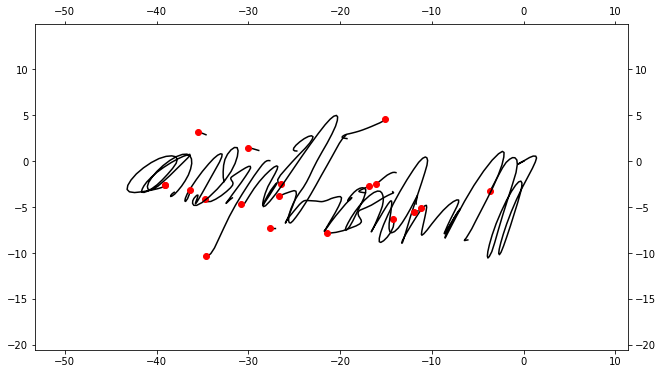

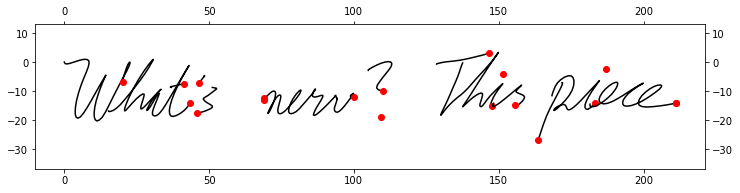

What 's new? This piece


In [8]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        #self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx] #, self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])


In [10]:
class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmLayer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(input_size+hidden_size, output_size)
        
    def forward(self, packed_input, h0, c0):
        packed_out1, (hn, cn) = self.lstmLayer(packed_input, (h0, c0))
        
        lin_layer_input = torch.cat(
            (packed_input.data, packed_out1.data), dim=-1)
        return self.linearLayer(lin_layer_input), (hn, cn)

In [11]:
def get_mixture_params_from_output(outputs):
    pis = nn.Softmax(1)(outputs[:,:n_mixtures])
    mus = outputs[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    
    sigmas = torch.exp(outputs[:, 3*n_mixtures:5*n_mixtures]).reshape(-1, n_mixtures, 2)
    phos = torch.tanh(outputs[:, 5*n_mixtures:6*n_mixtures]).reshape(-1, n_mixtures, 1)
    
    covs = torch.zeros(outputs.shape[0], n_mixtures, 2, 2, device=device)
    covs[:,:,0,0] = sigmas[:,:,0]**2
    covs[:,:,1,1] = sigmas[:,:,1]**2
    covs[:,:,0,1] = phos[:,:,0] * sigmas[:,:,0] * sigmas[:,:,1]
    covs[:,:,1,0] = covs[:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,-1]))

def nll(outputs, targets):
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords)
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=1)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    
    return loss_per_point.sum()/batch_size

In [12]:
def get_next_point(model, point_prev, h_prev, c_prev):
    with torch.no_grad():
        model_input = pack_padded_sequence(
            point_prev.unsqueeze(0).unsqueeze(0),
            torch.tensor([1]).cpu().numpy(),
            batch_first=True)
        outputs, (h_next, c_next) = model(model_input, h_prev, c_prev)
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), (h_next, c_next)
        
def sample(model):
    timestamps = max_length
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    h = torch.zeros(1, 1, hidden_size, device=device)
    c = torch.zeros(1, 1, hidden_size, device=device)
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, (h, c) = get_next_point(model, prev_point, h, c)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [13]:
def get_inputs_targets_from_batch(strokes_batch, lengths_batch):
    lengths_batch, perm_idx = lengths_batch.sort(0, descending=True)
    strokes_batch = strokes_batch[perm_idx]
    
    packed_inputs = pack_padded_sequence(
        strokes_batch,
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    targets = pack_padded_sequence(
        strokes_batch[:,1:,:],
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    return packed_inputs, targets

def train_batch(model, optimizer, strokes_batch, lengths_batch, h0, c0):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch, lengths_batch)
    outputs, _ = model(inputs, h0, c0)
    loss = nll(outputs, targets.data)
    loss.backward()
    #### Do Gradient clipping here if need be
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    h0 = torch.zeros(1, batch_size, hidden_size, device=device)
    c0 = torch.zeros(1, batch_size, hidden_size, device=device)
    
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch in train_dataloader:
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes_batch,
                lengths_batch,
                h0, c0)
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                sample_stroke = sample(model)
                sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [14]:
n_mixtures = 20
hidden_size = 900
input_size = 3
batch_size = 128
n_epochs = 1000
max_length = 1200
lr = 0.00001
model_name = "20210809_PredictionSimple-1LSTM-20Mixtures-900Hidden-128Batch"

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


iteration: 0 of 78000, avg_loss: 43.03, timeSinceStart: 2.59, Epoch: 0


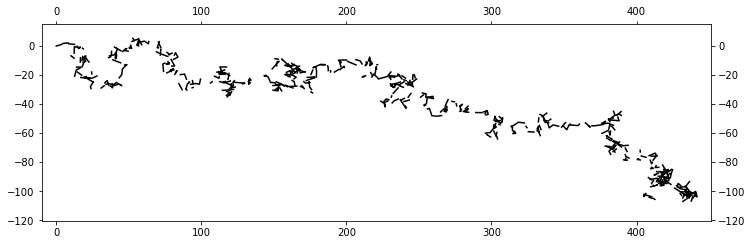

iteration: 50 of 78000, avg_loss: 2079.43, timeSinceStart: 29.06, Epoch: 0
iteration: 100 of 78000, avg_loss: 2026.45, timeSinceStart: 53.57, Epoch: 1
iteration: 150 of 78000, avg_loss: 1656.18, timeSinceStart: 78.50, Epoch: 1
iteration: 200 of 78000, avg_loss: 715.73, timeSinceStart: 103.60, Epoch: 2
iteration: 250 of 78000, avg_loss: 543.05, timeSinceStart: 128.52, Epoch: 3


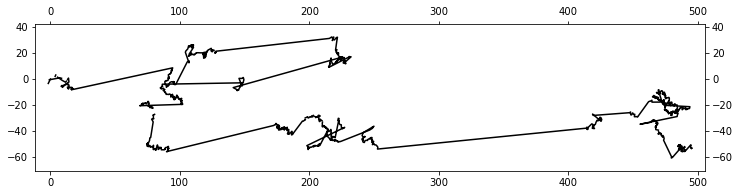

iteration: 300 of 78000, avg_loss: 432.30, timeSinceStart: 154.74, Epoch: 3
iteration: 350 of 78000, avg_loss: 345.27, timeSinceStart: 179.64, Epoch: 4
iteration: 400 of 78000, avg_loss: 707.66, timeSinceStart: 204.48, Epoch: 5
iteration: 450 of 78000, avg_loss: 607.91, timeSinceStart: 229.59, Epoch: 5
iteration: 500 of 78000, avg_loss: 482.61, timeSinceStart: 254.52, Epoch: 6


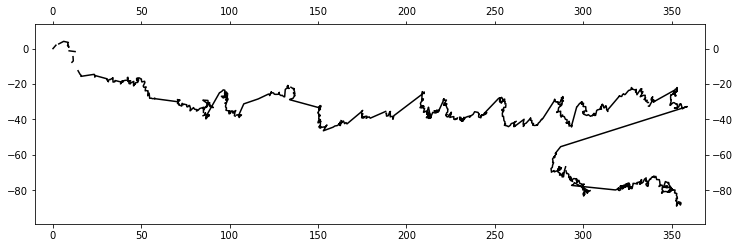

iteration: 550 of 78000, avg_loss: 496.44, timeSinceStart: 280.90, Epoch: 7
iteration: 600 of 78000, avg_loss: 684.86, timeSinceStart: 305.98, Epoch: 7
iteration: 650 of 78000, avg_loss: 469.46, timeSinceStart: 331.18, Epoch: 8
iteration: 700 of 78000, avg_loss: 476.96, timeSinceStart: 356.22, Epoch: 8
iteration: 750 of 78000, avg_loss: 560.41, timeSinceStart: 381.21, Epoch: 9


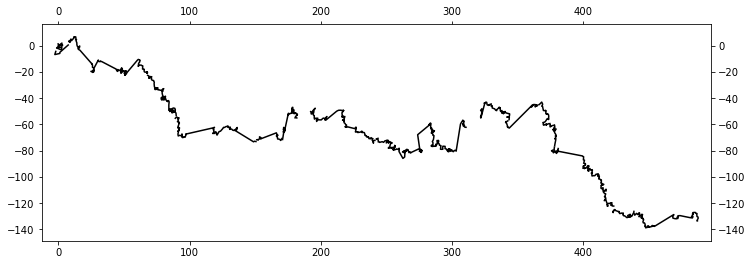

iteration: 800 of 78000, avg_loss: 439.47, timeSinceStart: 407.81, Epoch: 10
iteration: 850 of 78000, avg_loss: 713.31, timeSinceStart: 432.51, Epoch: 10
iteration: 900 of 78000, avg_loss: 619.23, timeSinceStart: 457.86, Epoch: 11
iteration: 950 of 78000, avg_loss: 526.88, timeSinceStart: 482.89, Epoch: 12
iteration: 1000 of 78000, avg_loss: 360.81, timeSinceStart: 507.94, Epoch: 12


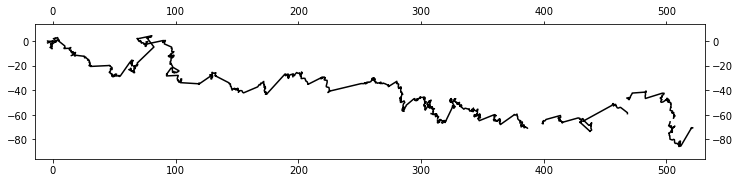

iteration: 1050 of 78000, avg_loss: 675.90, timeSinceStart: 534.22, Epoch: 13
iteration: 1100 of 78000, avg_loss: 652.86, timeSinceStart: 559.15, Epoch: 14
iteration: 1150 of 78000, avg_loss: 575.74, timeSinceStart: 584.11, Epoch: 14
iteration: 1200 of 78000, avg_loss: 430.15, timeSinceStart: 609.00, Epoch: 15
iteration: 1250 of 78000, avg_loss: 473.64, timeSinceStart: 634.15, Epoch: 16


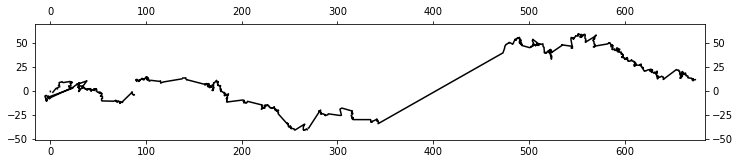

iteration: 1300 of 78000, avg_loss: 679.67, timeSinceStart: 660.43, Epoch: 16
iteration: 1350 of 78000, avg_loss: 642.59, timeSinceStart: 685.47, Epoch: 17
iteration: 1400 of 78000, avg_loss: 562.38, timeSinceStart: 710.45, Epoch: 17
iteration: 1450 of 78000, avg_loss: 311.43, timeSinceStart: 735.30, Epoch: 18
iteration: 1500 of 78000, avg_loss: 231.42, timeSinceStart: 760.48, Epoch: 19


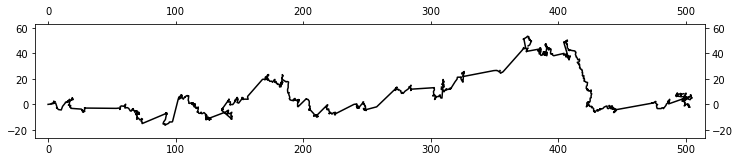

iteration: 1550 of 78000, avg_loss: 407.34, timeSinceStart: 786.96, Epoch: 19
iteration: 1600 of 78000, avg_loss: 637.13, timeSinceStart: 812.10, Epoch: 20
iteration: 1650 of 78000, avg_loss: 488.51, timeSinceStart: 837.11, Epoch: 21
iteration: 1700 of 78000, avg_loss: 338.12, timeSinceStart: 861.87, Epoch: 21
iteration: 1750 of 78000, avg_loss: 648.20, timeSinceStart: 886.84, Epoch: 22


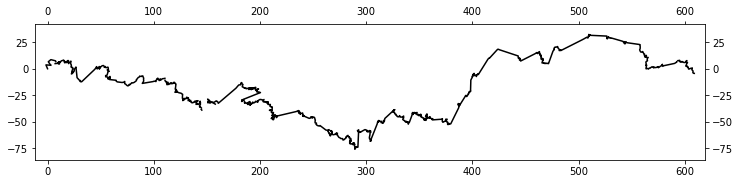

iteration: 1800 of 78000, avg_loss: 603.06, timeSinceStart: 913.15, Epoch: 23
iteration: 1850 of 78000, avg_loss: 588.56, timeSinceStart: 938.11, Epoch: 23
iteration: 1900 of 78000, avg_loss: 572.07, timeSinceStart: 963.11, Epoch: 24
iteration: 1950 of 78000, avg_loss: 464.27, timeSinceStart: 988.19, Epoch: 25
iteration: 2000 of 78000, avg_loss: 330.05, timeSinceStart: 1013.40, Epoch: 25


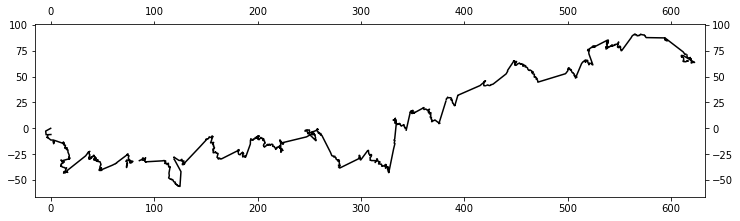

iteration: 2050 of 78000, avg_loss: 609.26, timeSinceStart: 1039.63, Epoch: 26
iteration: 2100 of 78000, avg_loss: 566.52, timeSinceStart: 1064.46, Epoch: 26
iteration: 2150 of 78000, avg_loss: 554.62, timeSinceStart: 1089.56, Epoch: 27
iteration: 2200 of 78000, avg_loss: 540.27, timeSinceStart: 1114.42, Epoch: 28
iteration: 2250 of 78000, avg_loss: 533.73, timeSinceStart: 1139.46, Epoch: 28


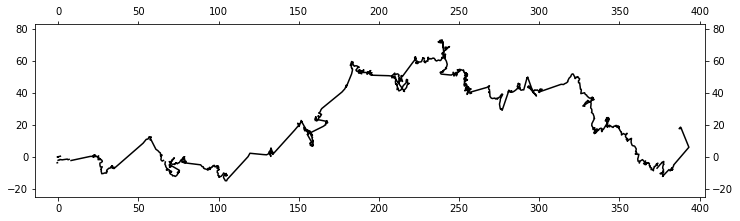

iteration: 2300 of 78000, avg_loss: 525.32, timeSinceStart: 1165.87, Epoch: 29
iteration: 2350 of 78000, avg_loss: 516.55, timeSinceStart: 1191.02, Epoch: 30
iteration: 2400 of 78000, avg_loss: 507.96, timeSinceStart: 1215.95, Epoch: 30
iteration: 2450 of 78000, avg_loss: 495.20, timeSinceStart: 1240.86, Epoch: 31
iteration: 2500 of 78000, avg_loss: 490.58, timeSinceStart: 1265.78, Epoch: 32


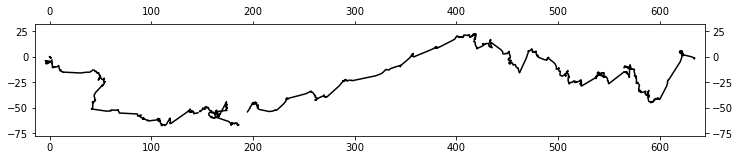

iteration: 2550 of 78000, avg_loss: 481.59, timeSinceStart: 1292.07, Epoch: 32
iteration: 2600 of 78000, avg_loss: 471.84, timeSinceStart: 1316.94, Epoch: 33
iteration: 2650 of 78000, avg_loss: 462.94, timeSinceStart: 1342.07, Epoch: 33
iteration: 2700 of 78000, avg_loss: 453.84, timeSinceStart: 1367.19, Epoch: 34
iteration: 2750 of 78000, avg_loss: 444.09, timeSinceStart: 1392.37, Epoch: 35


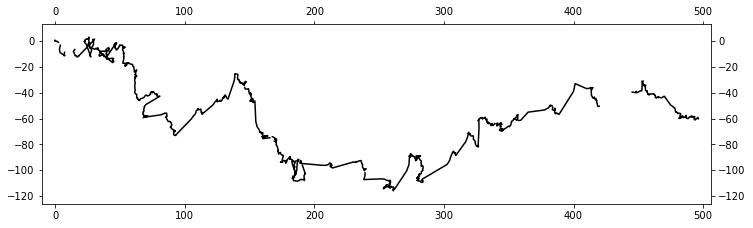

iteration: 2800 of 78000, avg_loss: 430.58, timeSinceStart: 1419.15, Epoch: 35
iteration: 2850 of 78000, avg_loss: 422.54, timeSinceStart: 1444.72, Epoch: 36
iteration: 2900 of 78000, avg_loss: 409.98, timeSinceStart: 1470.15, Epoch: 37
iteration: 2950 of 78000, avg_loss: 403.23, timeSinceStart: 1495.41, Epoch: 37
iteration: 3000 of 78000, avg_loss: 386.60, timeSinceStart: 1520.64, Epoch: 38


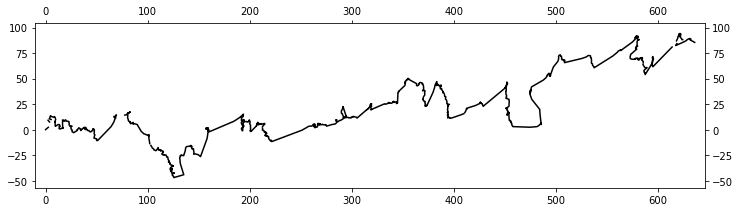

iteration: 3050 of 78000, avg_loss: 379.21, timeSinceStart: 1547.46, Epoch: 39
iteration: 3100 of 78000, avg_loss: 366.80, timeSinceStart: 1572.91, Epoch: 39
iteration: 3150 of 78000, avg_loss: 344.90, timeSinceStart: 1598.10, Epoch: 40
iteration: 3200 of 78000, avg_loss: 337.51, timeSinceStart: 1623.35, Epoch: 41
iteration: 3250 of 78000, avg_loss: 324.09, timeSinceStart: 1648.74, Epoch: 41


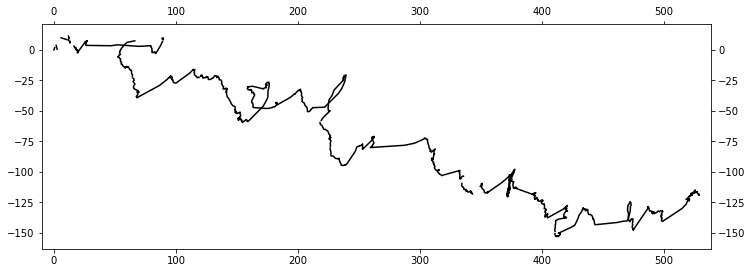

iteration: 3300 of 78000, avg_loss: 300.17, timeSinceStart: 1675.57, Epoch: 42
iteration: 3350 of 78000, avg_loss: 291.47, timeSinceStart: 1701.10, Epoch: 42
iteration: 3400 of 78000, avg_loss: 265.93, timeSinceStart: 1726.70, Epoch: 43
iteration: 3450 of 78000, avg_loss: 249.84, timeSinceStart: 1752.05, Epoch: 44
iteration: 3500 of 78000, avg_loss: 225.76, timeSinceStart: 1777.21, Epoch: 44


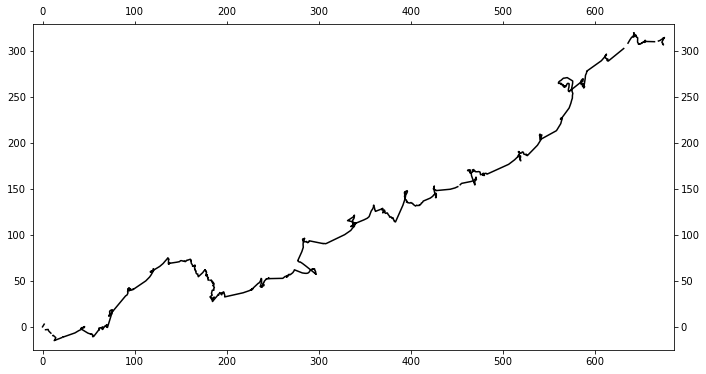

iteration: 3550 of 78000, avg_loss: 196.97, timeSinceStart: 1804.16, Epoch: 45
iteration: 3600 of 78000, avg_loss: 165.05, timeSinceStart: 1829.66, Epoch: 46
iteration: 3650 of 78000, avg_loss: 127.76, timeSinceStart: 1855.05, Epoch: 46
iteration: 3700 of 78000, avg_loss: 83.30, timeSinceStart: 1880.64, Epoch: 47
iteration: 3750 of 78000, avg_loss: 36.53, timeSinceStart: 1906.12, Epoch: 48


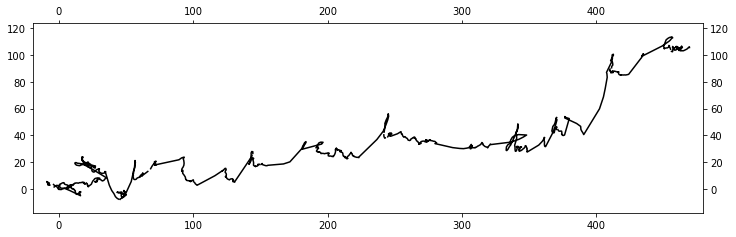

iteration: 3800 of 78000, avg_loss: -4.85, timeSinceStart: 1933.07, Epoch: 48
iteration: 3850 of 78000, avg_loss: -34.07, timeSinceStart: 1958.36, Epoch: 49
iteration: 3900 of 78000, avg_loss: -81.71, timeSinceStart: 1983.73, Epoch: 50
iteration: 3950 of 78000, avg_loss: -112.18, timeSinceStart: 2008.97, Epoch: 50
iteration: 4000 of 78000, avg_loss: -149.41, timeSinceStart: 2034.44, Epoch: 51


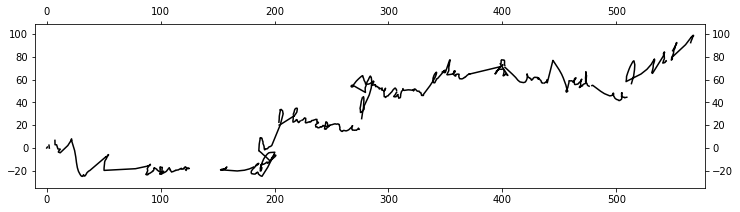

iteration: 4050 of 78000, avg_loss: -188.02, timeSinceStart: 2061.24, Epoch: 51
iteration: 4100 of 78000, avg_loss: -223.08, timeSinceStart: 2086.47, Epoch: 52
iteration: 4150 of 78000, avg_loss: -253.37, timeSinceStart: 2111.90, Epoch: 53
iteration: 4200 of 78000, avg_loss: -292.17, timeSinceStart: 2137.14, Epoch: 53
iteration: 4250 of 78000, avg_loss: -312.01, timeSinceStart: 2162.20, Epoch: 54


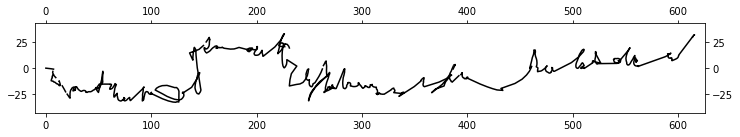

iteration: 4300 of 78000, avg_loss: -354.03, timeSinceStart: 2188.91, Epoch: 55
iteration: 4350 of 78000, avg_loss: -366.17, timeSinceStart: 2214.30, Epoch: 55
iteration: 4400 of 78000, avg_loss: -404.06, timeSinceStart: 2239.52, Epoch: 56
iteration: 4450 of 78000, avg_loss: -432.77, timeSinceStart: 2264.84, Epoch: 57
iteration: 4500 of 78000, avg_loss: -448.73, timeSinceStart: 2290.32, Epoch: 57


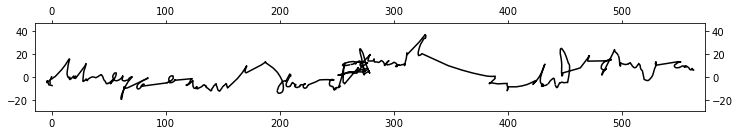

iteration: 4550 of 78000, avg_loss: -465.68, timeSinceStart: 2317.06, Epoch: 58
iteration: 4600 of 78000, avg_loss: -493.82, timeSinceStart: 2342.32, Epoch: 58
iteration: 4650 of 78000, avg_loss: -518.59, timeSinceStart: 2367.95, Epoch: 59
iteration: 4700 of 78000, avg_loss: -530.72, timeSinceStart: 2393.29, Epoch: 60
iteration: 4750 of 78000, avg_loss: -556.90, timeSinceStart: 2418.45, Epoch: 60


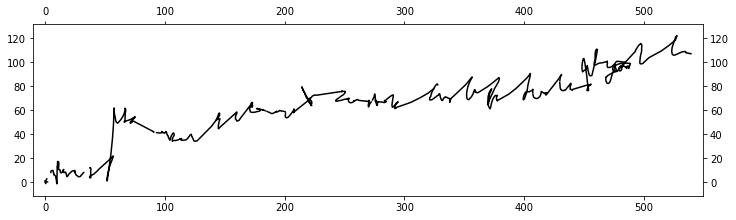

iteration: 4800 of 78000, avg_loss: -573.49, timeSinceStart: 2445.24, Epoch: 61
iteration: 4850 of 78000, avg_loss: -587.56, timeSinceStart: 2470.62, Epoch: 62
iteration: 4900 of 78000, avg_loss: -600.57, timeSinceStart: 2495.88, Epoch: 62
iteration: 4950 of 78000, avg_loss: -634.16, timeSinceStart: 2521.27, Epoch: 63
iteration: 5000 of 78000, avg_loss: -630.68, timeSinceStart: 2546.87, Epoch: 64


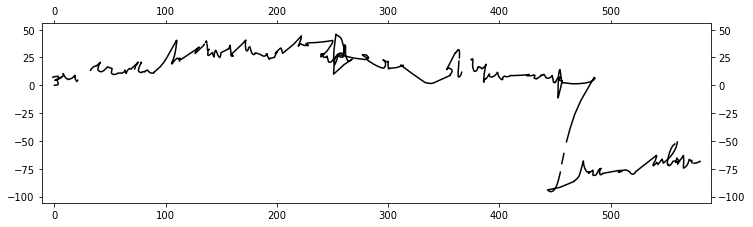

iteration: 5050 of 78000, avg_loss: -651.64, timeSinceStart: 2573.48, Epoch: 64
iteration: 5100 of 78000, avg_loss: -677.98, timeSinceStart: 2599.03, Epoch: 65
iteration: 5150 of 78000, avg_loss: -678.18, timeSinceStart: 2624.48, Epoch: 66
iteration: 5200 of 78000, avg_loss: -694.99, timeSinceStart: 2649.77, Epoch: 66
iteration: 5250 of 78000, avg_loss: -709.63, timeSinceStart: 2675.13, Epoch: 67


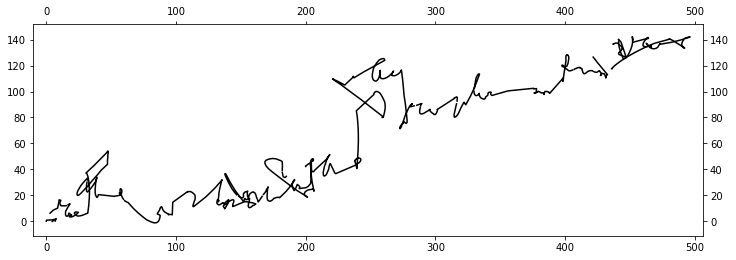

iteration: 5300 of 78000, avg_loss: -727.63, timeSinceStart: 2702.02, Epoch: 67
iteration: 5350 of 78000, avg_loss: -741.17, timeSinceStart: 2727.57, Epoch: 68
iteration: 5400 of 78000, avg_loss: -752.12, timeSinceStart: 2753.00, Epoch: 69
iteration: 5450 of 78000, avg_loss: -767.55, timeSinceStart: 2778.29, Epoch: 69
iteration: 5500 of 78000, avg_loss: -764.11, timeSinceStart: 2803.71, Epoch: 70


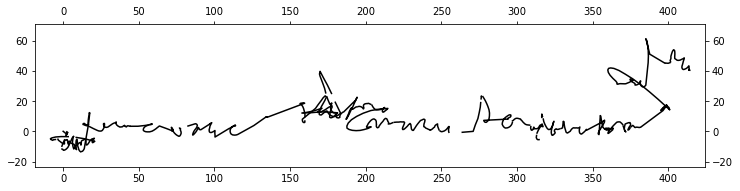

iteration: 5550 of 78000, avg_loss: -785.95, timeSinceStart: 2830.37, Epoch: 71
iteration: 5600 of 78000, avg_loss: -799.23, timeSinceStart: 2855.71, Epoch: 71
iteration: 5650 of 78000, avg_loss: -812.44, timeSinceStart: 2881.27, Epoch: 72
iteration: 5700 of 78000, avg_loss: -823.38, timeSinceStart: 2906.44, Epoch: 73
iteration: 5750 of 78000, avg_loss: -836.64, timeSinceStart: 2931.91, Epoch: 73


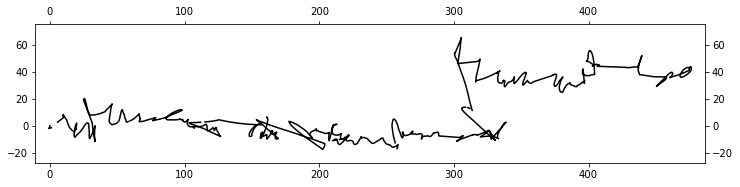

iteration: 5800 of 78000, avg_loss: -841.73, timeSinceStart: 2958.47, Epoch: 74
iteration: 5850 of 78000, avg_loss: -861.23, timeSinceStart: 2983.99, Epoch: 75
iteration: 5900 of 78000, avg_loss: -872.25, timeSinceStart: 3009.39, Epoch: 75
iteration: 5950 of 78000, avg_loss: -882.82, timeSinceStart: 3034.72, Epoch: 76
iteration: 6000 of 78000, avg_loss: -897.71, timeSinceStart: 3059.80, Epoch: 76


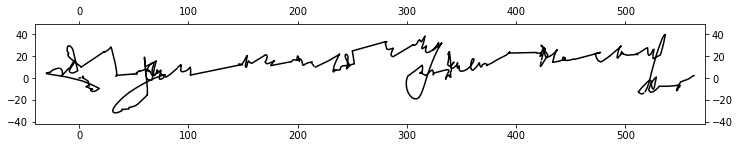

iteration: 6050 of 78000, avg_loss: -917.44, timeSinceStart: 3086.55, Epoch: 77
iteration: 6100 of 78000, avg_loss: -924.62, timeSinceStart: 3112.08, Epoch: 78
iteration: 6150 of 78000, avg_loss: -947.62, timeSinceStart: 3137.42, Epoch: 78
iteration: 6200 of 78000, avg_loss: -985.90, timeSinceStart: 3162.74, Epoch: 79
iteration: 6250 of 78000, avg_loss: -994.63, timeSinceStart: 3188.15, Epoch: 80


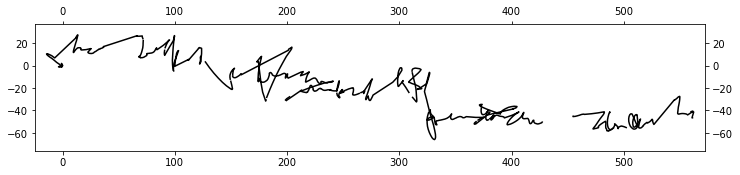

iteration: 6300 of 78000, avg_loss: -1033.40, timeSinceStart: 3215.01, Epoch: 80
iteration: 6350 of 78000, avg_loss: -1042.37, timeSinceStart: 3240.26, Epoch: 81
iteration: 6400 of 78000, avg_loss: -994.02, timeSinceStart: 3265.57, Epoch: 82
iteration: 6450 of 78000, avg_loss: -1078.87, timeSinceStart: 3290.82, Epoch: 82
iteration: 6500 of 78000, avg_loss: -1002.30, timeSinceStart: 3316.38, Epoch: 83


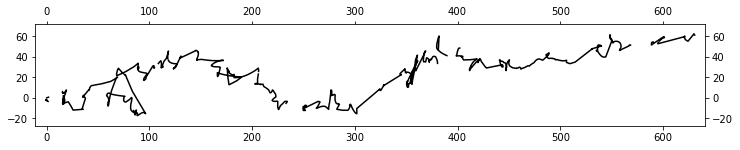

iteration: 6550 of 78000, avg_loss: -957.53, timeSinceStart: 3343.30, Epoch: 83
iteration: 6600 of 78000, avg_loss: -1003.09, timeSinceStart: 3368.43, Epoch: 84
iteration: 6650 of 78000, avg_loss: -1028.62, timeSinceStart: 3393.98, Epoch: 85
iteration: 6700 of 78000, avg_loss: -1034.68, timeSinceStart: 3419.12, Epoch: 85
iteration: 6750 of 78000, avg_loss: -1057.29, timeSinceStart: 3444.49, Epoch: 86


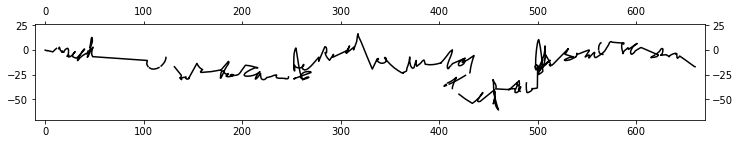

iteration: 6800 of 78000, avg_loss: -1137.41, timeSinceStart: 3471.29, Epoch: 87
iteration: 6850 of 78000, avg_loss: -938.93, timeSinceStart: 3496.54, Epoch: 87
iteration: 6900 of 78000, avg_loss: -995.55, timeSinceStart: 3521.69, Epoch: 88
iteration: 6950 of 78000, avg_loss: -1058.13, timeSinceStart: 3546.74, Epoch: 89
iteration: 7000 of 78000, avg_loss: -1087.68, timeSinceStart: 3572.11, Epoch: 89


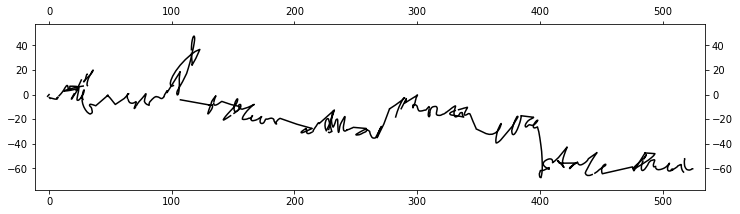

iteration: 7050 of 78000, avg_loss: -1095.31, timeSinceStart: 3599.00, Epoch: 90
iteration: 7100 of 78000, avg_loss: -1146.85, timeSinceStart: 3624.64, Epoch: 91
iteration: 7150 of 78000, avg_loss: -1099.95, timeSinceStart: 3649.90, Epoch: 91
iteration: 7200 of 78000, avg_loss: -1108.60, timeSinceStart: 3675.33, Epoch: 92
iteration: 7250 of 78000, avg_loss: -1217.15, timeSinceStart: 3700.77, Epoch: 92


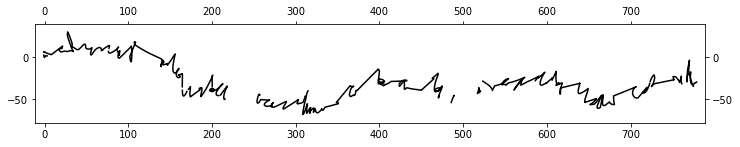

iteration: 7300 of 78000, avg_loss: -1035.59, timeSinceStart: 3727.67, Epoch: 93
iteration: 7350 of 78000, avg_loss: -1213.08, timeSinceStart: 3753.09, Epoch: 94
iteration: 7400 of 78000, avg_loss: -1188.24, timeSinceStart: 3778.49, Epoch: 94
iteration: 7450 of 78000, avg_loss: -976.49, timeSinceStart: 3803.74, Epoch: 95
iteration: 7500 of 78000, avg_loss: -1090.47, timeSinceStart: 3828.97, Epoch: 96


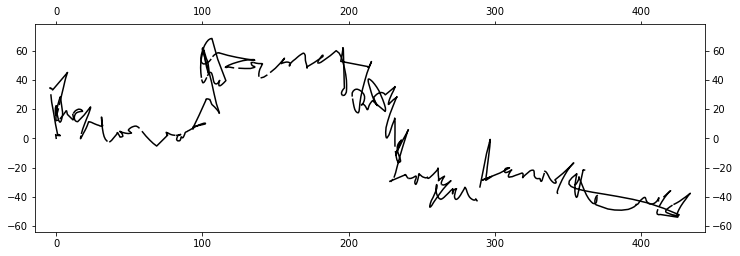

iteration: 7550 of 78000, avg_loss: -1141.35, timeSinceStart: 3855.73, Epoch: 96
iteration: 7600 of 78000, avg_loss: -1169.26, timeSinceStart: 3881.26, Epoch: 97
iteration: 7650 of 78000, avg_loss: -1262.57, timeSinceStart: 3906.60, Epoch: 98
iteration: 7700 of 78000, avg_loss: -1298.88, timeSinceStart: 3931.94, Epoch: 98
iteration: 7750 of 78000, avg_loss: -1319.61, timeSinceStart: 3957.17, Epoch: 99


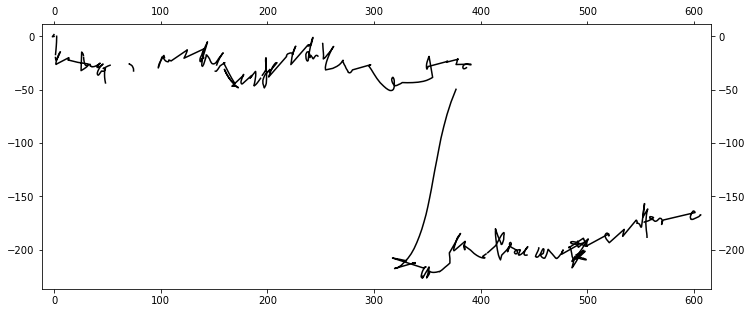

iteration: 7800 of 78000, avg_loss: -1151.94, timeSinceStart: 3984.04, Epoch: 100
iteration: 7850 of 78000, avg_loss: -1143.00, timeSinceStart: 4009.49, Epoch: 100
iteration: 7900 of 78000, avg_loss: -1197.05, timeSinceStart: 4034.91, Epoch: 101
iteration: 7950 of 78000, avg_loss: -1192.15, timeSinceStart: 4060.55, Epoch: 101
iteration: 8000 of 78000, avg_loss: -1330.85, timeSinceStart: 4086.15, Epoch: 102


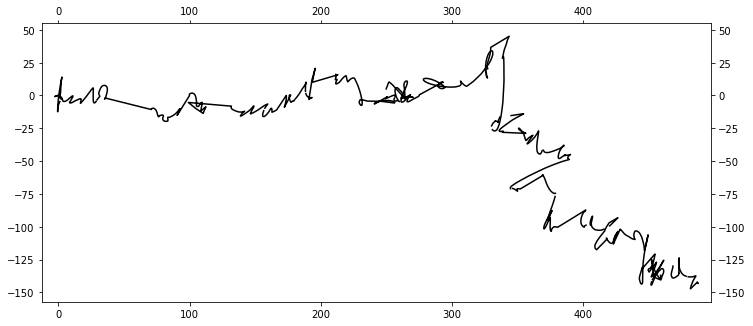

iteration: 8050 of 78000, avg_loss: -1377.65, timeSinceStart: 4113.08, Epoch: 103
iteration: 8100 of 78000, avg_loss: -1025.95, timeSinceStart: 4138.38, Epoch: 103
iteration: 8150 of 78000, avg_loss: -1202.76, timeSinceStart: 4163.81, Epoch: 104
iteration: 8200 of 78000, avg_loss: -1218.61, timeSinceStart: 4188.97, Epoch: 105
iteration: 8250 of 78000, avg_loss: -1188.43, timeSinceStart: 4214.39, Epoch: 105


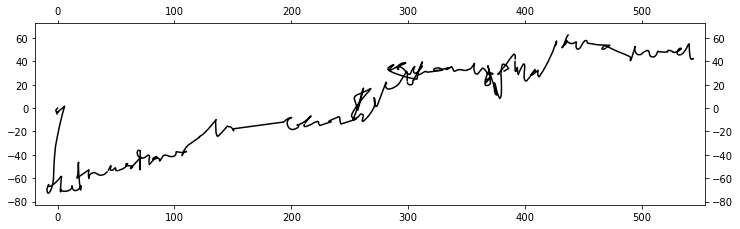

iteration: 8300 of 78000, avg_loss: -1205.45, timeSinceStart: 4241.13, Epoch: 106
iteration: 8350 of 78000, avg_loss: -1269.87, timeSinceStart: 4266.05, Epoch: 107
iteration: 8400 of 78000, avg_loss: -1212.30, timeSinceStart: 4291.50, Epoch: 107
iteration: 8450 of 78000, avg_loss: -1226.15, timeSinceStart: 4316.75, Epoch: 108
iteration: 8500 of 78000, avg_loss: -1185.93, timeSinceStart: 4342.06, Epoch: 108


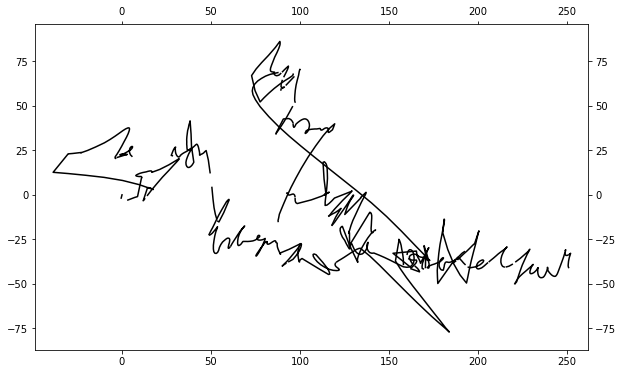

iteration: 8550 of 78000, avg_loss: -1257.31, timeSinceStart: 4368.98, Epoch: 109
iteration: 8600 of 78000, avg_loss: -1265.58, timeSinceStart: 4394.63, Epoch: 110
iteration: 8650 of 78000, avg_loss: -1258.70, timeSinceStart: 4420.08, Epoch: 110
iteration: 8700 of 78000, avg_loss: -1343.51, timeSinceStart: 4445.47, Epoch: 111
iteration: 8750 of 78000, avg_loss: -1381.41, timeSinceStart: 4470.72, Epoch: 112


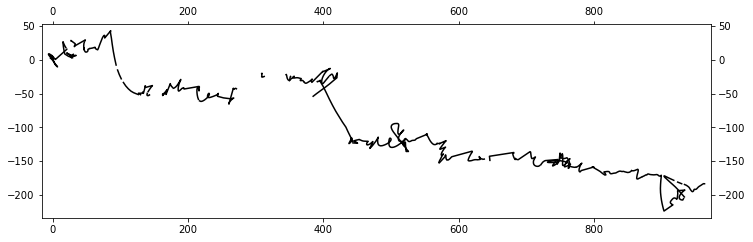

iteration: 8800 of 78000, avg_loss: -1154.81, timeSinceStart: 4497.79, Epoch: 112
iteration: 8850 of 78000, avg_loss: -1277.91, timeSinceStart: 4523.00, Epoch: 113
iteration: 8900 of 78000, avg_loss: -1319.78, timeSinceStart: 4548.36, Epoch: 114
iteration: 8950 of 78000, avg_loss: -1331.18, timeSinceStart: 4573.76, Epoch: 114
iteration: 9000 of 78000, avg_loss: -1452.73, timeSinceStart: 4599.29, Epoch: 115


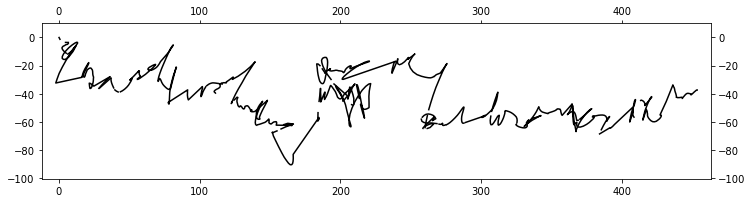

iteration: 9050 of 78000, avg_loss: -1302.43, timeSinceStart: 4625.89, Epoch: 116
iteration: 9100 of 78000, avg_loss: -1261.95, timeSinceStart: 4651.27, Epoch: 116
iteration: 9150 of 78000, avg_loss: -1439.38, timeSinceStart: 4676.79, Epoch: 117
iteration: 9200 of 78000, avg_loss: -1445.90, timeSinceStart: 4702.33, Epoch: 117
iteration: 9250 of 78000, avg_loss: -1388.13, timeSinceStart: 4727.60, Epoch: 118


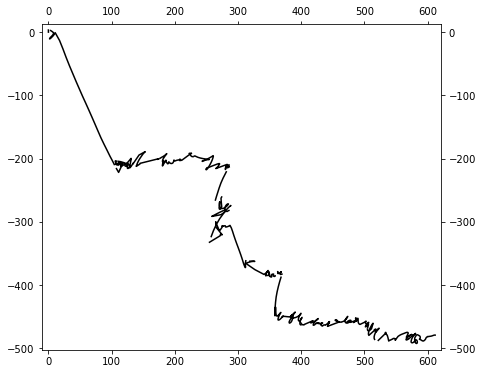

iteration: 9300 of 78000, avg_loss: -1268.72, timeSinceStart: 4754.32, Epoch: 119
iteration: 9350 of 78000, avg_loss: -1342.70, timeSinceStart: 4779.57, Epoch: 119
iteration: 9400 of 78000, avg_loss: -1354.15, timeSinceStart: 4805.08, Epoch: 120
iteration: 9450 of 78000, avg_loss: -1411.88, timeSinceStart: 4830.60, Epoch: 121
iteration: 9500 of 78000, avg_loss: -1481.58, timeSinceStart: 4855.78, Epoch: 121


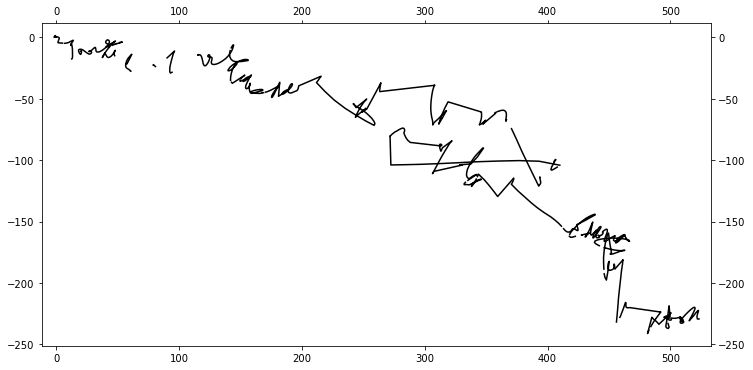

iteration: 9550 of 78000, avg_loss: -1295.90, timeSinceStart: 4882.76, Epoch: 122
iteration: 9600 of 78000, avg_loss: -1463.44, timeSinceStart: 4908.32, Epoch: 123
iteration: 9650 of 78000, avg_loss: -1429.70, timeSinceStart: 4933.73, Epoch: 123
iteration: 9700 of 78000, avg_loss: -1286.98, timeSinceStart: 4958.86, Epoch: 124
iteration: 9750 of 78000, avg_loss: -1291.98, timeSinceStart: 4984.41, Epoch: 125


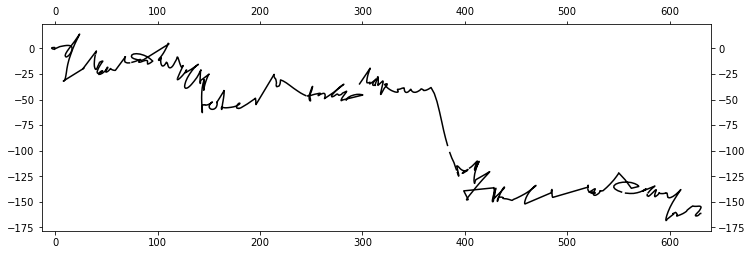

iteration: 9800 of 78000, avg_loss: -1417.80, timeSinceStart: 5011.40, Epoch: 125
iteration: 9850 of 78000, avg_loss: -1411.48, timeSinceStart: 5036.82, Epoch: 126
iteration: 9900 of 78000, avg_loss: -1218.82, timeSinceStart: 5062.06, Epoch: 126
iteration: 9950 of 78000, avg_loss: -1441.36, timeSinceStart: 5087.59, Epoch: 127
iteration: 10000 of 78000, avg_loss: -1370.32, timeSinceStart: 5113.16, Epoch: 128


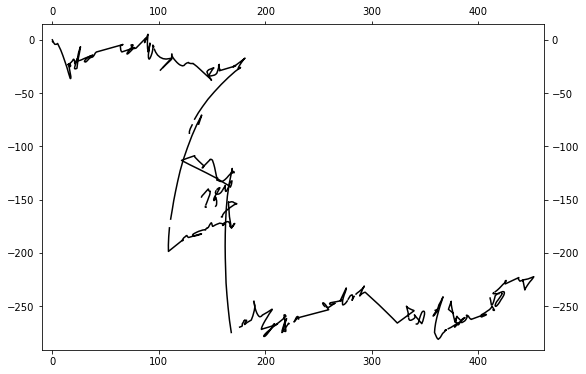

iteration: 10050 of 78000, avg_loss: -1352.29, timeSinceStart: 5139.81, Epoch: 128
iteration: 10100 of 78000, avg_loss: -1493.54, timeSinceStart: 5165.10, Epoch: 129
iteration: 10150 of 78000, avg_loss: -1573.24, timeSinceStart: 5190.58, Epoch: 130
iteration: 10200 of 78000, avg_loss: -1437.52, timeSinceStart: 5215.80, Epoch: 130
iteration: 10250 of 78000, avg_loss: -1555.00, timeSinceStart: 5241.05, Epoch: 131


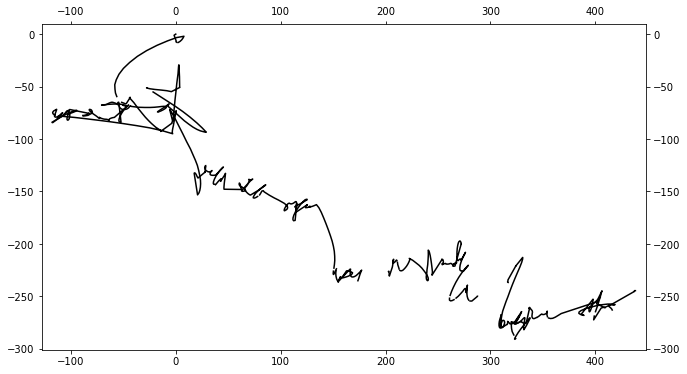

iteration: 10300 of 78000, avg_loss: -1323.11, timeSinceStart: 5267.93, Epoch: 132
iteration: 10350 of 78000, avg_loss: -1440.56, timeSinceStart: 5293.19, Epoch: 132
iteration: 10400 of 78000, avg_loss: -1339.19, timeSinceStart: 5318.61, Epoch: 133
iteration: 10450 of 78000, avg_loss: -1496.39, timeSinceStart: 5344.07, Epoch: 133
iteration: 10500 of 78000, avg_loss: -1371.95, timeSinceStart: 5369.68, Epoch: 134


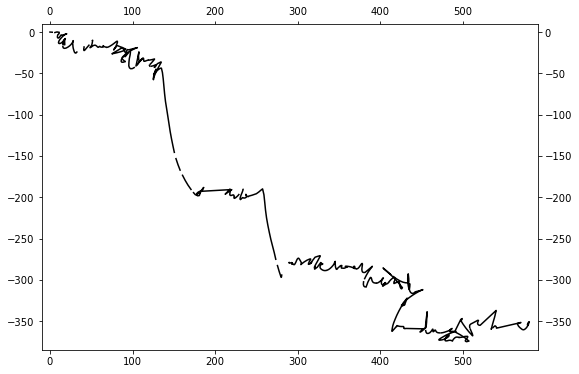

iteration: 10550 of 78000, avg_loss: -1465.34, timeSinceStart: 5396.33, Epoch: 135
iteration: 10600 of 78000, avg_loss: -1402.69, timeSinceStart: 5421.99, Epoch: 135
iteration: 10650 of 78000, avg_loss: -1535.85, timeSinceStart: 5447.35, Epoch: 136
iteration: 10700 of 78000, avg_loss: -1470.36, timeSinceStart: 5472.93, Epoch: 137
iteration: 10750 of 78000, avg_loss: -1563.79, timeSinceStart: 5498.55, Epoch: 137


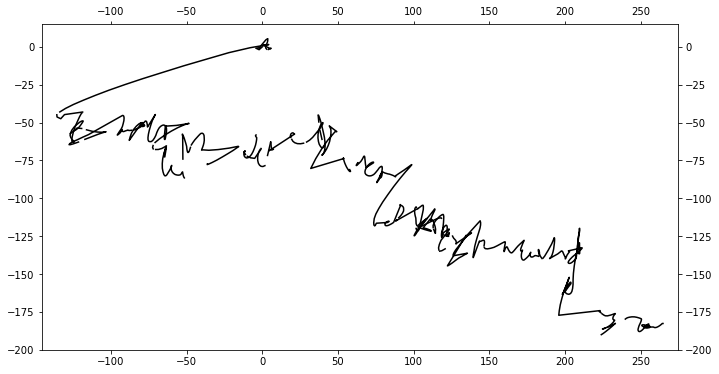

iteration: 10800 of 78000, avg_loss: -1372.82, timeSinceStart: 5525.31, Epoch: 138
iteration: 10850 of 78000, avg_loss: -1432.45, timeSinceStart: 5550.74, Epoch: 139
iteration: 10900 of 78000, avg_loss: -1504.46, timeSinceStart: 5576.04, Epoch: 139
iteration: 10950 of 78000, avg_loss: -1317.72, timeSinceStart: 5601.27, Epoch: 140
iteration: 11000 of 78000, avg_loss: -1507.77, timeSinceStart: 5626.62, Epoch: 141


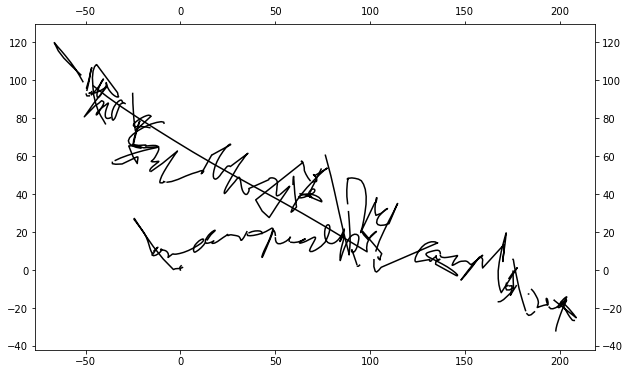

iteration: 11050 of 78000, avg_loss: -1406.05, timeSinceStart: 5653.48, Epoch: 141
iteration: 11100 of 78000, avg_loss: -1343.35, timeSinceStart: 5678.96, Epoch: 142
iteration: 11150 of 78000, avg_loss: -1522.80, timeSinceStart: 5704.18, Epoch: 142
iteration: 11200 of 78000, avg_loss: -1309.52, timeSinceStart: 5729.29, Epoch: 143
iteration: 11250 of 78000, avg_loss: -1503.94, timeSinceStart: 5754.70, Epoch: 144


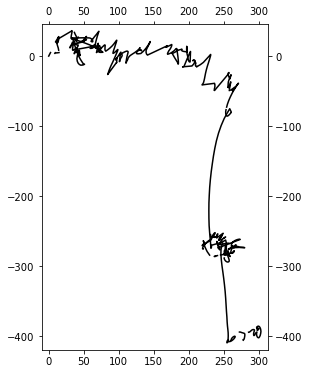

iteration: 11300 of 78000, avg_loss: -1427.70, timeSinceStart: 5781.76, Epoch: 144
iteration: 11350 of 78000, avg_loss: -1466.56, timeSinceStart: 5806.60, Epoch: 145
iteration: 11400 of 78000, avg_loss: -1554.21, timeSinceStart: 5831.11, Epoch: 146
iteration: 11450 of 78000, avg_loss: -1608.97, timeSinceStart: 5855.71, Epoch: 146
iteration: 11500 of 78000, avg_loss: -1449.53, timeSinceStart: 5880.20, Epoch: 147


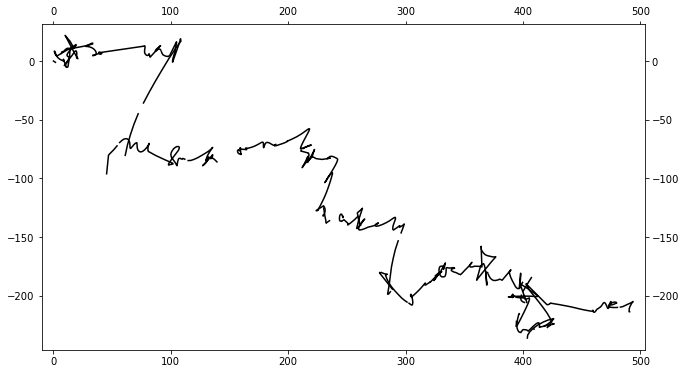

iteration: 11550 of 78000, avg_loss: -1543.02, timeSinceStart: 5906.09, Epoch: 148
iteration: 11600 of 78000, avg_loss: -1388.18, timeSinceStart: 5930.61, Epoch: 148
iteration: 11650 of 78000, avg_loss: -1582.74, timeSinceStart: 5955.14, Epoch: 149
iteration: 11700 of 78000, avg_loss: -1419.08, timeSinceStart: 5979.56, Epoch: 150
iteration: 11750 of 78000, avg_loss: -1435.81, timeSinceStart: 6004.10, Epoch: 150


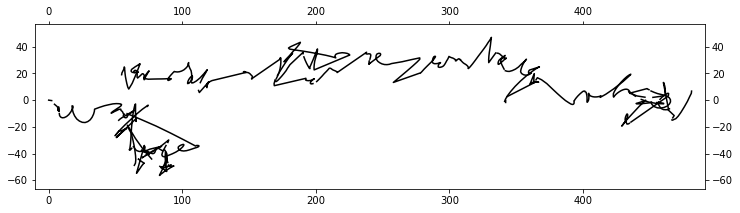

iteration: 11800 of 78000, avg_loss: -1568.29, timeSinceStart: 6029.84, Epoch: 151
iteration: 11850 of 78000, avg_loss: -1326.91, timeSinceStart: 6054.30, Epoch: 151
iteration: 11900 of 78000, avg_loss: -1454.34, timeSinceStart: 6078.74, Epoch: 152
iteration: 11950 of 78000, avg_loss: -1292.71, timeSinceStart: 6103.18, Epoch: 153
iteration: 12000 of 78000, avg_loss: -1433.55, timeSinceStart: 6127.46, Epoch: 153


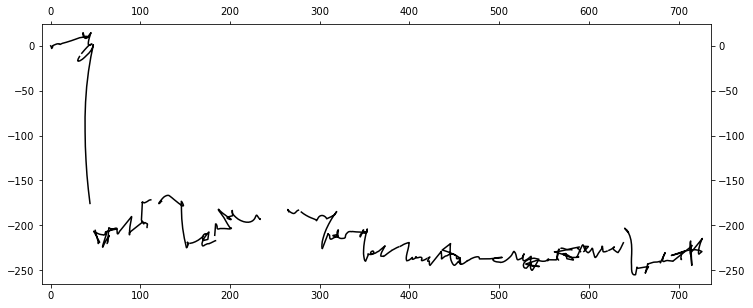

iteration: 12050 of 78000, avg_loss: -1342.37, timeSinceStart: 6153.15, Epoch: 154
iteration: 12100 of 78000, avg_loss: -1455.09, timeSinceStart: 6177.52, Epoch: 155
iteration: 12150 of 78000, avg_loss: -1519.74, timeSinceStart: 6202.05, Epoch: 155
iteration: 12200 of 78000, avg_loss: -1557.25, timeSinceStart: 6226.46, Epoch: 156
iteration: 12250 of 78000, avg_loss: -1555.65, timeSinceStart: 6251.10, Epoch: 157


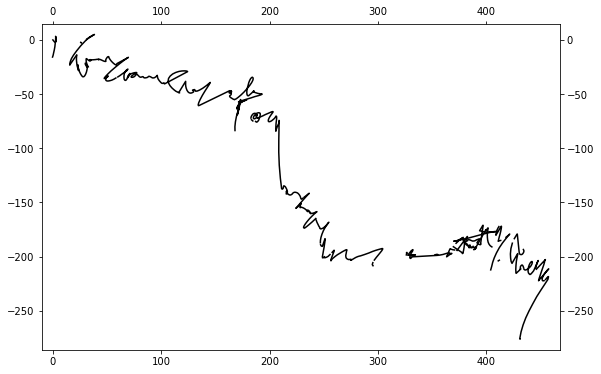

iteration: 12300 of 78000, avg_loss: -1560.26, timeSinceStart: 6276.76, Epoch: 157
iteration: 12350 of 78000, avg_loss: -1655.80, timeSinceStart: 6301.23, Epoch: 158
iteration: 12400 of 78000, avg_loss: -1528.08, timeSinceStart: 6325.60, Epoch: 158
iteration: 12450 of 78000, avg_loss: -1635.61, timeSinceStart: 6349.82, Epoch: 159
iteration: 12500 of 78000, avg_loss: -1568.11, timeSinceStart: 6374.26, Epoch: 160


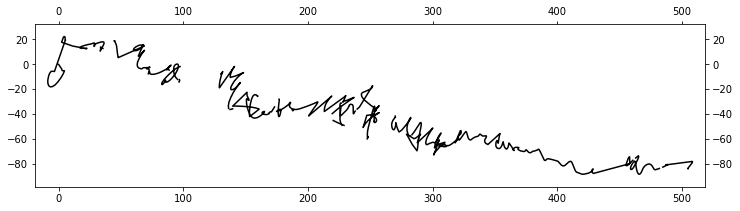

iteration: 12550 of 78000, avg_loss: -1552.14, timeSinceStart: 6399.89, Epoch: 160
iteration: 12600 of 78000, avg_loss: -1477.53, timeSinceStart: 6424.11, Epoch: 161
iteration: 12650 of 78000, avg_loss: -1430.29, timeSinceStart: 6448.79, Epoch: 162
iteration: 12700 of 78000, avg_loss: -1464.52, timeSinceStart: 6473.26, Epoch: 162
iteration: 12750 of 78000, avg_loss: -1613.11, timeSinceStart: 6497.72, Epoch: 163


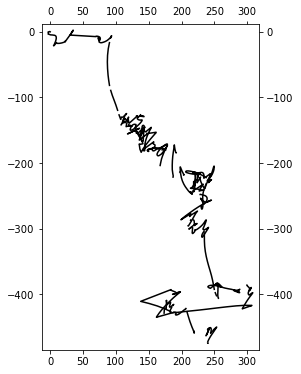

iteration: 12800 of 78000, avg_loss: -1579.69, timeSinceStart: 6523.56, Epoch: 164
iteration: 12850 of 78000, avg_loss: -1535.28, timeSinceStart: 6547.96, Epoch: 164
iteration: 12900 of 78000, avg_loss: -1655.07, timeSinceStart: 6572.32, Epoch: 165
iteration: 12950 of 78000, avg_loss: -1609.36, timeSinceStart: 6596.77, Epoch: 166
iteration: 13000 of 78000, avg_loss: -1686.89, timeSinceStart: 6621.46, Epoch: 166


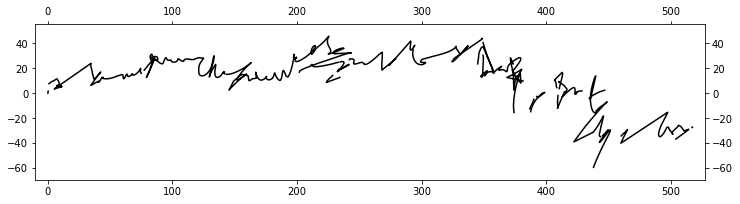

iteration: 13050 of 78000, avg_loss: -1655.12, timeSinceStart: 6647.21, Epoch: 167
iteration: 13100 of 78000, avg_loss: -1705.50, timeSinceStart: 6671.71, Epoch: 167
iteration: 13150 of 78000, avg_loss: -1607.12, timeSinceStart: 6696.24, Epoch: 168
iteration: 13200 of 78000, avg_loss: -1421.05, timeSinceStart: 6720.75, Epoch: 169
iteration: 13250 of 78000, avg_loss: -1436.91, timeSinceStart: 6745.22, Epoch: 169


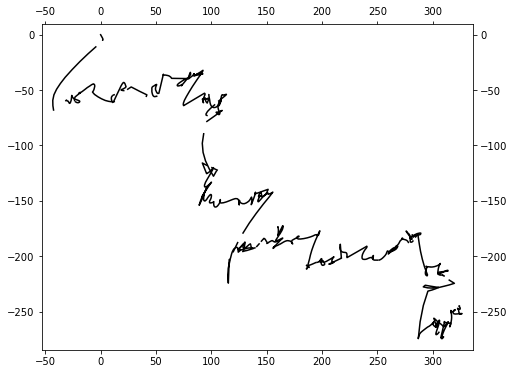

iteration: 13300 of 78000, avg_loss: -1357.55, timeSinceStart: 6770.90, Epoch: 170
iteration: 13350 of 78000, avg_loss: -1576.38, timeSinceStart: 6795.32, Epoch: 171
iteration: 13400 of 78000, avg_loss: -1442.49, timeSinceStart: 6819.86, Epoch: 171
iteration: 13450 of 78000, avg_loss: -1644.76, timeSinceStart: 6844.28, Epoch: 172
iteration: 13500 of 78000, avg_loss: -1388.16, timeSinceStart: 6868.91, Epoch: 173


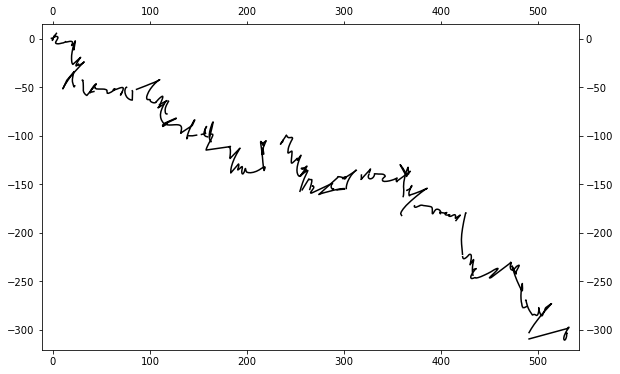

iteration: 13550 of 78000, avg_loss: -1549.50, timeSinceStart: 6894.87, Epoch: 173
iteration: 13600 of 78000, avg_loss: -1523.46, timeSinceStart: 6919.44, Epoch: 174
iteration: 13650 of 78000, avg_loss: -1642.05, timeSinceStart: 6943.72, Epoch: 175
iteration: 13700 of 78000, avg_loss: -1524.20, timeSinceStart: 6968.12, Epoch: 175
iteration: 13750 of 78000, avg_loss: -1403.83, timeSinceStart: 6992.63, Epoch: 176


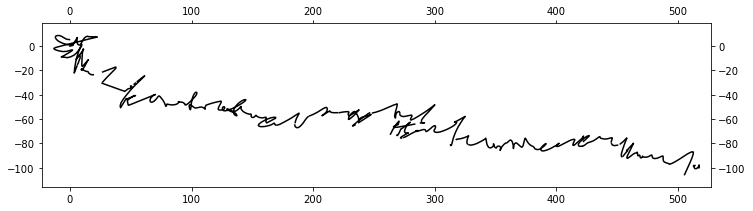

iteration: 13800 of 78000, avg_loss: -1500.74, timeSinceStart: 7018.31, Epoch: 176
iteration: 13850 of 78000, avg_loss: -1456.59, timeSinceStart: 7042.84, Epoch: 177
iteration: 13900 of 78000, avg_loss: -1615.46, timeSinceStart: 7067.23, Epoch: 178
iteration: 13950 of 78000, avg_loss: -1524.14, timeSinceStart: 7091.83, Epoch: 178
iteration: 14000 of 78000, avg_loss: -1683.28, timeSinceStart: 7116.27, Epoch: 179


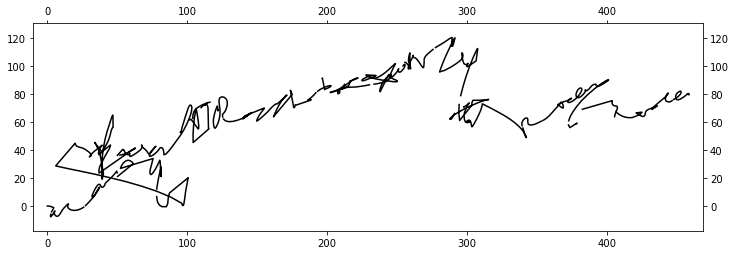

iteration: 14050 of 78000, avg_loss: -1407.16, timeSinceStart: 7142.07, Epoch: 180
iteration: 14100 of 78000, avg_loss: -1664.42, timeSinceStart: 7166.63, Epoch: 180
iteration: 14150 of 78000, avg_loss: -1564.62, timeSinceStart: 7191.10, Epoch: 181
iteration: 14200 of 78000, avg_loss: -1448.18, timeSinceStart: 7215.40, Epoch: 182
iteration: 14250 of 78000, avg_loss: -1677.08, timeSinceStart: 7240.00, Epoch: 182


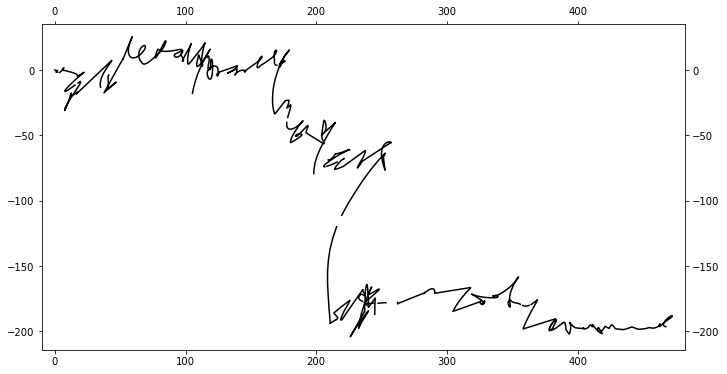

iteration: 14300 of 78000, avg_loss: -1435.41, timeSinceStart: 7265.78, Epoch: 183
iteration: 14350 of 78000, avg_loss: -1686.45, timeSinceStart: 7290.19, Epoch: 183
iteration: 14400 of 78000, avg_loss: -1556.83, timeSinceStart: 7314.69, Epoch: 184
iteration: 14450 of 78000, avg_loss: -1453.92, timeSinceStart: 7339.25, Epoch: 185
iteration: 14500 of 78000, avg_loss: -1591.99, timeSinceStart: 7363.61, Epoch: 185


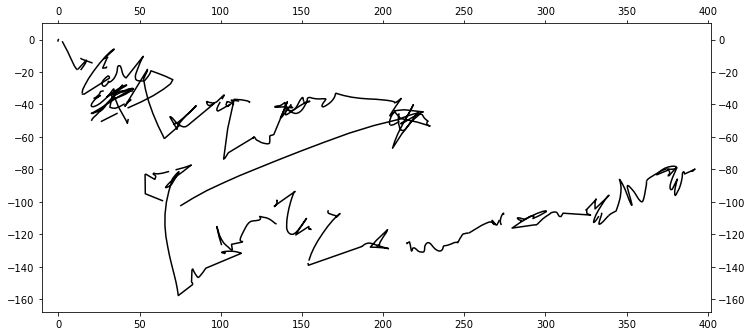

iteration: 14550 of 78000, avg_loss: -1610.65, timeSinceStart: 7389.32, Epoch: 186
iteration: 14600 of 78000, avg_loss: -1675.24, timeSinceStart: 7413.86, Epoch: 187
iteration: 14650 of 78000, avg_loss: -1399.31, timeSinceStart: 7438.26, Epoch: 187
iteration: 14700 of 78000, avg_loss: -1683.54, timeSinceStart: 7462.77, Epoch: 188
iteration: 14750 of 78000, avg_loss: -1604.82, timeSinceStart: 7487.33, Epoch: 189


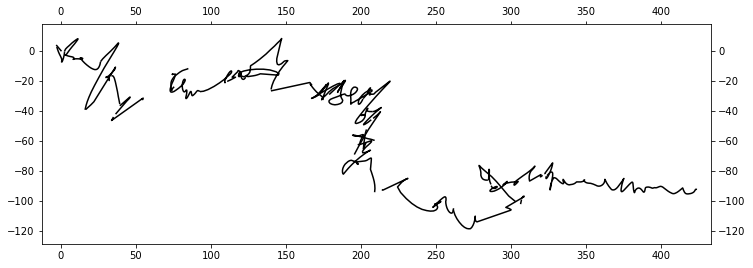

iteration: 14800 of 78000, avg_loss: -1609.06, timeSinceStart: 7513.27, Epoch: 189
iteration: 14850 of 78000, avg_loss: -1705.31, timeSinceStart: 7537.77, Epoch: 190
iteration: 14900 of 78000, avg_loss: -1624.12, timeSinceStart: 7562.12, Epoch: 191
iteration: 14950 of 78000, avg_loss: -1442.01, timeSinceStart: 7586.70, Epoch: 191
iteration: 15000 of 78000, avg_loss: -1614.80, timeSinceStart: 7611.41, Epoch: 192


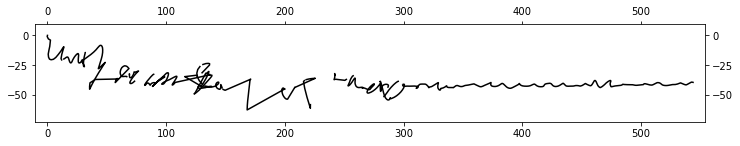

iteration: 15050 of 78000, avg_loss: -1666.52, timeSinceStart: 7637.01, Epoch: 192
iteration: 15100 of 78000, avg_loss: -1710.26, timeSinceStart: 7661.74, Epoch: 193
iteration: 15150 of 78000, avg_loss: -1766.94, timeSinceStart: 7686.15, Epoch: 194
iteration: 15200 of 78000, avg_loss: -1388.80, timeSinceStart: 7710.75, Epoch: 194
iteration: 15250 of 78000, avg_loss: -1465.08, timeSinceStart: 7735.29, Epoch: 195


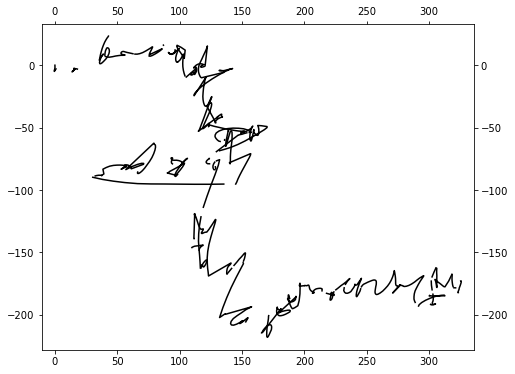

iteration: 15300 of 78000, avg_loss: -1625.09, timeSinceStart: 7761.06, Epoch: 196
iteration: 15350 of 78000, avg_loss: -1661.11, timeSinceStart: 7785.44, Epoch: 196
iteration: 15400 of 78000, avg_loss: -1502.13, timeSinceStart: 7810.06, Epoch: 197
iteration: 15450 of 78000, avg_loss: -1613.68, timeSinceStart: 7834.55, Epoch: 198
iteration: 15500 of 78000, avg_loss: -1647.47, timeSinceStart: 7859.05, Epoch: 198


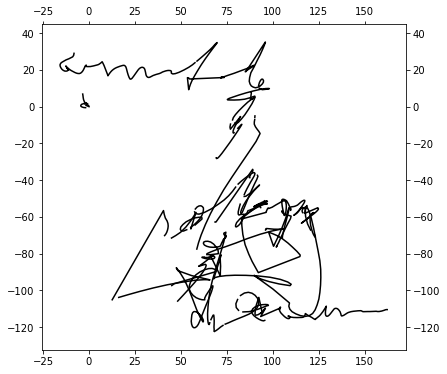

iteration: 15550 of 78000, avg_loss: -1656.06, timeSinceStart: 7884.69, Epoch: 199
iteration: 15600 of 78000, avg_loss: -1615.43, timeSinceStart: 7909.20, Epoch: 200
iteration: 15650 of 78000, avg_loss: -1472.85, timeSinceStart: 7933.55, Epoch: 200
iteration: 15700 of 78000, avg_loss: -1719.67, timeSinceStart: 7958.36, Epoch: 201
iteration: 15750 of 78000, avg_loss: -1567.96, timeSinceStart: 7982.72, Epoch: 201


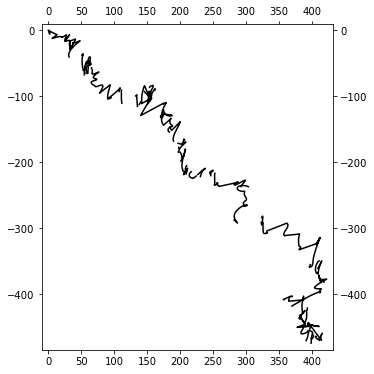

iteration: 15800 of 78000, avg_loss: -1451.73, timeSinceStart: 8008.82, Epoch: 202
iteration: 15850 of 78000, avg_loss: -1525.95, timeSinceStart: 8033.28, Epoch: 203
iteration: 15900 of 78000, avg_loss: -1606.49, timeSinceStart: 8057.71, Epoch: 203
iteration: 15950 of 78000, avg_loss: -1736.83, timeSinceStart: 8081.99, Epoch: 204
iteration: 16000 of 78000, avg_loss: -1651.58, timeSinceStart: 8106.33, Epoch: 205


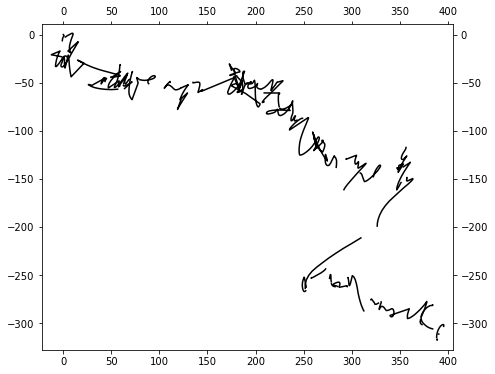

iteration: 16050 of 78000, avg_loss: -1526.25, timeSinceStart: 8132.18, Epoch: 205
iteration: 16100 of 78000, avg_loss: -1560.51, timeSinceStart: 8156.55, Epoch: 206
iteration: 16150 of 78000, avg_loss: -1585.21, timeSinceStart: 8181.28, Epoch: 207
iteration: 16200 of 78000, avg_loss: -1468.16, timeSinceStart: 8205.72, Epoch: 207
iteration: 16250 of 78000, avg_loss: -1611.95, timeSinceStart: 8230.29, Epoch: 208


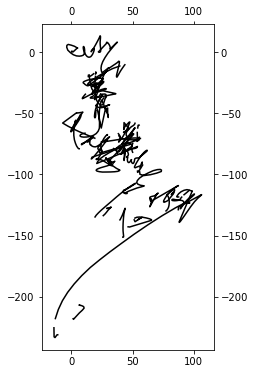

iteration: 16300 of 78000, avg_loss: -1656.94, timeSinceStart: 8256.04, Epoch: 208
iteration: 16350 of 78000, avg_loss: -1711.64, timeSinceStart: 8280.39, Epoch: 209


In [ ]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
